<a href="https://colab.research.google.com/github/TANKIANAUN/Learning/blob/master/FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from sklearn.metrics import confusion_matrix

In [0]:
data=pd.read_csv("310_23498_compressed_creditcard.csv.zip")

In [0]:
data=data.head(50000)


In [45]:
data.shape

(50000, 31)

In [46]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [47]:
data.groupby(['Class']).count()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852,49852
1,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148,148


In [0]:
#data engineering

In [0]:
data=data.drop(['Time'],axis=1)

In [0]:
data['Amount']=StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

In [0]:
x_train,x_test=train_test_split(data,test_size=0.2,random_state=0)

In [0]:
x_train=x_train.drop(['Class'],axis=1)

In [0]:
y_test=x_test['Class']

In [0]:
x_test=x_test.drop(['Class'],axis=1)

In [0]:
x_train=x_train.values

In [0]:
x_test=x_test.values

In [57]:
x_train.shape,x_test.shape

((40000, 29), (10000, 29))

In [0]:
#autoencoder model

In [0]:
input_dim=x_train.shape[1]
encoding_dim=15

In [0]:
model=Sequential()

In [67]:
model.add(Dense(encoding_dim, activation="tanh", input_shape=(input_dim,)))
model.add(Dense(int(encoding_dim / 2), activation="relu"))
model.add(Dense(int(encoding_dim / 2), activation='tanh'))
model.add(Dense(input_dim, activation='relu'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15)                450       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_3 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_4 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 112       
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_7 (Dense)              (None, 29)               

In [0]:
#model training

In [70]:
n_epoch=40
batch_size=32
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])
history = model.fit(x_train, x_train,
                    epochs=n_epoch,
                    batch_size=batch_size,
                    validation_data=(x_test, x_test),
                    verbose=1)

autoencoder = model

Train on 40000 samples, validate on 10000 samples
Epoch 1/40
40000/40000 [==============================] - 9s 216us/step - loss: 1.0205 - acc: 0.4374 - val_loss: 0.9871 - val_acc: 0.5254
Epoch 2/40
40000/40000 [==============================] - 7s 175us/step - loss: 0.9250 - acc: 0.5628 - val_loss: 0.9374 - val_acc: 0.5884
Epoch 3/40
40000/40000 [==============================] - 7s 175us/step - loss: 0.8944 - acc: 0.5947 - val_loss: 0.9160 - val_acc: 0.6014
Epoch 4/40
40000/40000 [==============================] - 7s 175us/step - loss: 0.8764 - acc: 0.6134 - val_loss: 0.9027 - val_acc: 0.6259
Epoch 5/40
40000/40000 [==============================] - 7s 177us/step - loss: 0.8648 - acc: 0.6346 - val_loss: 0.8924 - val_acc: 0.6500
Epoch 6/40
40000/40000 [==============================] - 7s 175us/step - loss: 0.8563 - acc: 0.6528 - val_loss: 0.8856 - val_acc: 0.6537
Epoch 7/40
40000/40000 [==============================] - 7s 176us/step - loss: 0.8454 - acc: 0.6633 - val_loss: 0.8720 - 

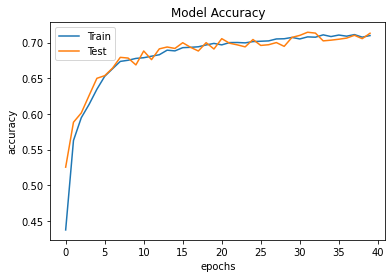

In [74]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['Train','Test'],loc='upper left')
plt.show()

In [0]:
#prediction

In [0]:
prediction=autoencoder.predict(x_test)
mse=np.mean(np.power(x_test-prediction,2),axis=1)
error_df=pd.DataFrame({'reconstruction_error':mse,'true_class':y_test})

In [87]:
error_df.head()

,reconstruction_error,true_class
11841,72.718721,1
19602,0.667606,0
45519,0.499657,0
25747,0.252386,0
42642,0.154635,0


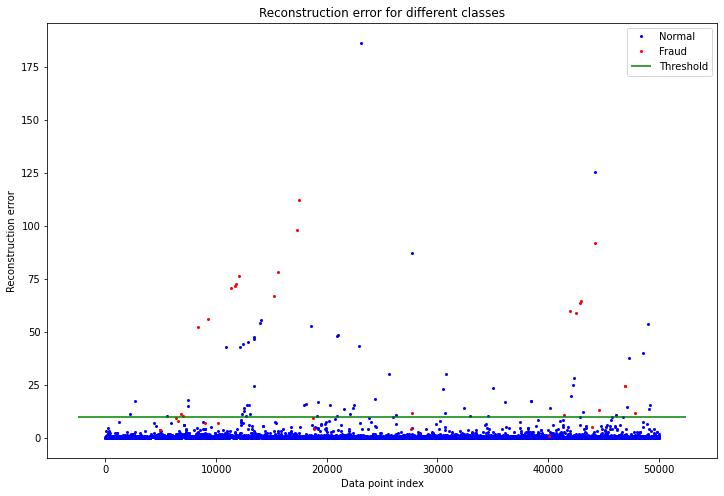

In [91]:
threshold = 10.0

groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(12, 8))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=2.0, linestyle='',
            label = "Fraud" if name == 1 else "Normal",
            color = "red" if name == 1 else "blue")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="green", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [92]:
normal = error_df[error_df.true_class == 0]
fraud = error_df[error_df.true_class == 1]

print('Normal transactions: %d, fraud transactions: %d' % (len(normal), len(fraud)))

Normal transactions: 9967, fraud transactions: 33


In [93]:
true_positives = len(fraud[fraud.reconstruction_error >= threshold])
false_positives = len(normal[normal.reconstruction_error >= threshold])

true_negatives = len(normal[normal.reconstruction_error < threshold])
false_negatives = len(fraud[fraud.reconstruction_error < threshold])

print('True positives: %d, true negatives: %d' % (true_positives, true_negatives))
print('False positives: %d, false negatives: %d' % (false_positives, false_negatives))

True positives: 23, true negatives: 9902
False positives: 65, false negatives: 10


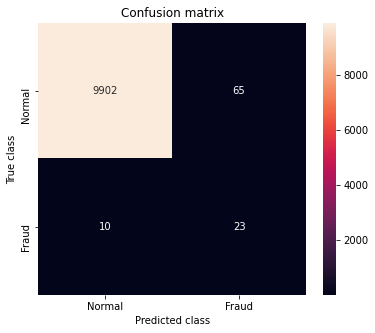

In [94]:
#confusion matrix
labels = ["Normal", "Fraud"]

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()